# 중고차 판매 가격 예측 모델 구축
### 사용 라이브러리

In [103]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import category_encoders as ce

from scipy.stats import boxcox, zscore, probplot, shapiro
from scipy.special import inv_boxcox

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBRegressor, plot_importance

# from dask_ml.model_selection import HyperbandSearchCV

# from IPython.display import display

# import time

### 데이터 불러오기

In [2]:
# 데이터 불러오기
df = pd.read_parquet('./data/vehicle_final.parquet').reset_index(drop=True)
df.head()

,region,price,model_year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,type,state,lat,long,odometer_per_age,avg_autoTheftPerPop
0,auburn,33590,2014,gmc,sierra,8,gas,57923.0,other,rwd,pickup,al,32.590,-85.4800,6435.888889,229.8
1,auburn,22590,2010,chevrolet,silverado,8,gas,71229.0,other,rwd,pickup,al,32.590,-85.4800,5479.153846,229.8
2,auburn,39590,2020,chevrolet,silverado,8,gas,19160.0,other,rwd,pickup,al,32.590,-85.4800,6386.666667,229.8
3,auburn,30990,2017,toyota,tundra,8,gas,41124.0,other,rwd,pickup,al,32.590,-85.4800,6854.0,229.8
4,auburn,15000,2013,ford,f-150 xlt,6,gas,128000.0,automatic,rwd,truck,al,32.592,-85.5189,12800.0,229.8


In [3]:
# 컬럼명 변환
df.rename(columns={'avg_autoTheftPerPop': 'autoTheftPerPop'}, inplace=True)

In [4]:
# model_year를 연식(age) 컬럼으로 변환
df['age'] = 2023 - df['model_year']

## 범주형 피쳐 인코딩
인코딩 방법으론 One-hot-encoding과 Binary기법을 사용했습니다.

각 피쳐의 고유값 개수가 20개 이상인 경우 Binary, 적으면 One-hot-encoding을 사용했습니다.

참고출저: https://medium.com/@kevin.menear/comparing-label-encoding-one-hot-encoding-and-binary-encoding-for-handling-categorical-variables-933544ccbd02#:~:text=Information%20Loss%3A%20Binary%20encoding%20can,performance%20of%20machine%20learning%20models.

In [5]:
# 범주형 피쳐의 고유값 개수 확인 
df[['manufacturer', 'model', 'fuel', 'transmission', 'drive', 'type']].nunique()

manufacturer      67
model           6969
fuel               5
transmission       3
drive              5
type              13
dtype: int64

In [6]:
# 컬럼들을 그룹으로 나누기
binenc_columns = ['manufacturer', 'model']
ohenc_columns = ['fuel', 'transmission', 'drive', 'type']
numerical_columns = ['age', 'odometer_per_age', 'autoTheftPerPop', 'cylinders']
feature_columns = ['manufacturer', 'model', 'age', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'odometer_per_age', 'autoTheftPerPop']
label_column = 'price'

In [7]:
# ce모듈의 BinaryEncoder를 사용하여 고유값 개수가 많은 범주형 변수를 이진수로 인코딩
bin_encoder = ce.BinaryEncoder(cols=binenc_columns)
df_encoded_tmp = df.loc[:, feature_columns+[label_column]]
df_encoded = bin_encoder.fit_transform(df_encoded_tmp)

# sklearn의 OneHotEncoder를 사용하여 고유값 개수가 적은 범주형 변수를 인코딩
oh_encoder = OneHotEncoder(sparse_output=False)
oh_encoded = oh_encoder.fit_transform(df_encoded_tmp[ohenc_columns])
oh_encoded_df = pd.DataFrame(oh_encoded, columns=oh_encoder.get_feature_names_out(ohenc_columns))

# 인코딩된 데이터프레임을 합치기
df_encoded = pd.concat([df_encoded, oh_encoded_df], axis=1).drop(columns=ohenc_columns, axis=1)

In [8]:
df_encoded.columns

Index(['manufacturer_0', 'manufacturer_1', 'manufacturer_2', 'manufacturer_3',
       'manufacturer_4', 'manufacturer_5', 'manufacturer_6', 'model_0',
       'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6',
       'model_7', 'model_8', 'model_9', 'model_10', 'model_11', 'model_12',
       'age', 'cylinders', 'odometer_per_age', 'autoTheftPerPop', 'price',
       'fuel_diesel', 'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other',
       'transmission_automatic', 'transmission_manual', 'transmission_other',
       'drive_4wd', 'drive_awd', 'drive_fwd', 'drive_other', 'drive_rwd',
       'type_SUV', 'type_bus', 'type_convertible', 'type_coupe',
       'type_hatchback', 'type_mini-van', 'type_offroad', 'type_other',
       'type_pickup', 'type_sedan', 'type_truck', 'type_van', 'type_wagon'],
      dtype='object')

## 종속 변수의 정규화
예측 값인 Price를 정규분포 형태로 만들면 회귀모델의 잔차가 정규분포를 따를 가능성이 높아집니다.

이에 Box-cox Transformation을 Price컬럼에 적용하겠습니다.

In [9]:
# Boxcox 변환
prices_boxcox, lambda_ = boxcox(df_encoded[label_column])
print(lambda_)

0.3566340899953841


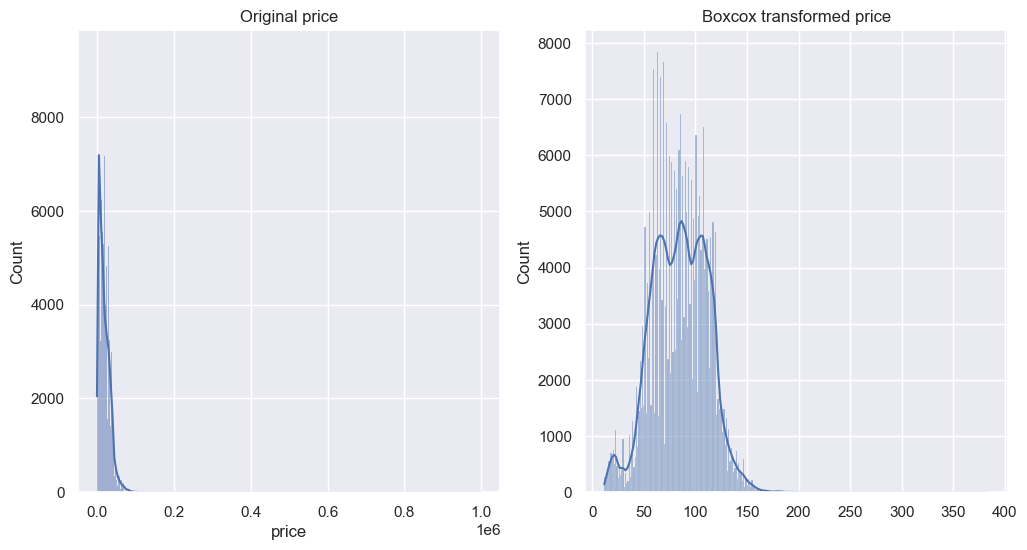

In [10]:
# Boxcox로 변환한 가격을 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_encoded[label_column], kde=True)
plt.title('Original price')
plt.subplot(1, 2, 2)
sns.histplot(prices_boxcox, kde=True)
plt.title('Boxcox transformed price')
plt.show()

$\lambda$ 값이 0.357인것을 볼 수 있습니다.
- lambda가 0: logarithmic transformation이랑 동일
- lambda가 0.5: square root transformation이랑 동일

결과해석을 용이성을 위해 간단한 square root transformation을 사용하여 종속변수를 정규화 하겠습니다.

## 학습 및 예측 데이터로 분할

In [11]:
# 피쳐 컬럼 다시 정의
feature_columns_encoded = df_encoded.columns.difference([label_column])

X = df_encoded[feature_columns_encoded]
y = np.sqrt(df_encoded[label_column])  # 제곱근으로 변환

# 학습:예측 = 8:2의 비율로 데이터를 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
len(df_encoded), len(X_train), len(X_test)

(298485, 238788, 59697)

## 데이터 표준화

In [13]:
# 수치형 변수의 스케일을 맞추기 위해 StandardScaler를 사용
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

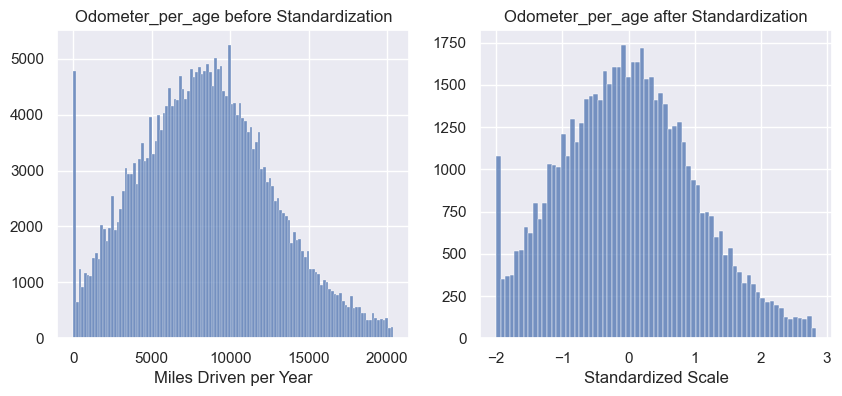

In [14]:
# 정규화하기 전후 데이터 시각화
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df_encoded['odometer_per_age'], ax=ax[0])
ax[0].set_title('Odometer_per_age before Standardization')
ax[0].set_xlabel('Miles Driven per Year')
ax[0].set_ylabel('')

sns.histplot(X_test['odometer_per_age'], ax=ax[1])
ax[1].set_title('Odometer_per_age after Standardization')
ax[1].set_xlabel('Standardized Scale')
ax[1].set_ylabel('')
plt.tight_layout
plt.show()

---
#### 모델 성능 평가 및 시각화 함수 정의

In [15]:
# 성능 평가 지표를 생성할 딕셔너리 생성
eval_metrics_dict = {}

# 모델의 성능을 평가하고 출력하는 함수
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name='Linear Regression', show_feature_importance=False):
    '''
    모델의 성능을 평가하고 출력하는 함수
    '''
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 성능 평가 지표 계산
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 성능 평가 지표를 딕셔너리에 저장
    eval_metrics_dict[model_name] = {'Train MAE': train_mae, 'Test MAE': test_mae,
                                     'Train MSE': train_mse, 'Test MSE': test_mse,
                                     'Train RMSE': train_rmse, 'Test RMSE': test_rmse,
                                     'Train R^2': train_r2, 'Test R^2': test_r2}
    
    # 성능 평가 지표를 데이터프레임으로 변환
    eval_metrics_df = pd.DataFrame(eval_metrics_dict[model_name], index=[model_name])
    
    return eval_metrics_df

In [16]:
def plt_model(model, y_test, y_pred, model_name='Linear Regression', show_feature_importance=False, n_features=10):
    '''
    모델의 예측 결과 및 피쳐 중요도 시각화 함수
    '''
    # 모델의 예측 결과 시각화
    figure, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.scatterplot(y=y_test, x=y_pred, alpha=0.5, ax=ax[0])
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    ax[0].set_xlabel("Prices: $Y_i$")
    ax[0].set_ylabel("Predicted prices: $\hat{Y}_i$")
    ax[0].set_title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$ - "+model_name)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    
    if show_feature_importance:
        # 모델의 피쳐 중요도 계산
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:min(n_features, len(importances))]  # 상위 7개 피쳐만 시각화
    
        # 모델의 피쳐 중요도 시각화
        sns.barplot(x=importances[indices], y=X.columns[indices], hue=X.columns[indices], dodge=False,
                    palette='viridis', ax=ax[1])
        ax[1].set_title(f'{model_name} Feature Importances')
        ax[1].set_xlabel('Feature Importance')
        ax[1].set_ylabel('Feature')
    else:
        # 안 쓰는 서브플롯 삭제
        figure.delaxes(ax[1])
        
    plt.tight_layout()
    plt.show

---
## 모델 학습 및 예측

### 1. Linear Regression Model

In [17]:
# 선형 회귀 모델을 학습
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression()

In [18]:
# 선형 회귀 모델의 성능 평가
evaluate_model(lin_reg, X_train, X_test, y_train, y_test, 'Linear Regression')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Linear Regression,20.164879,20.177666,986.535521,997.712459,31.409163,31.586587,0.646238,0.643736


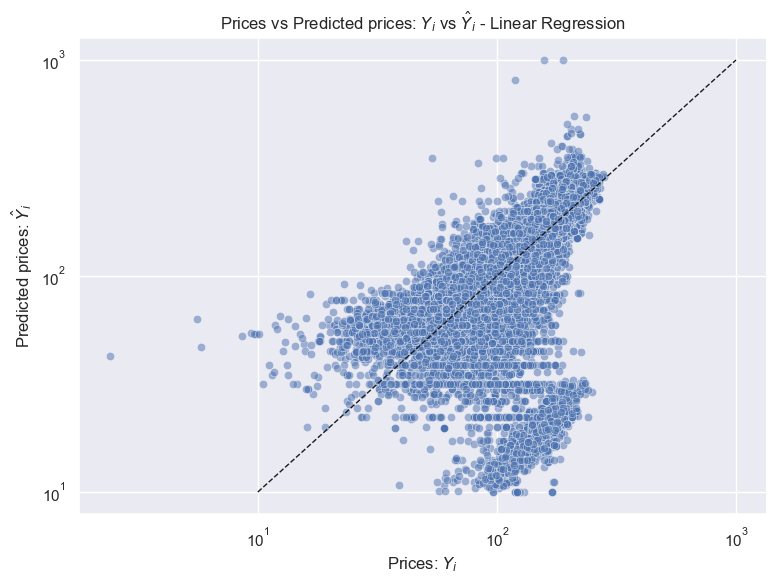

In [19]:
# 선형 회귀 모델의 예측 결과 시각화
y_test_pred_lin_reg = lin_reg.predict(X_test)

plt_model(lin_reg, y_test, y_test_pred_lin_reg, 'Linear Regression', show_feature_importance=False)

---
#### *만약 수치형 변수들만 사용한다면?*

In [20]:
# 선형 회귀 모델을 학습
lin_reg_num_cols = LinearRegression()

X_train_num_cols = X_train[numerical_columns]
X_test_num_cols = X_test[numerical_columns]
lin_reg_num_cols.fit(X_train_num_cols, y_train)

LinearRegression()

In [21]:
# 선형 회귀 모델의 성능 평가
evaluate_model(lin_reg_num_cols, X_train_num_cols, X_test_num_cols, y_train, y_test, 'Linear Regression (only numerical features)')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Linear Regression (only numerical features),23.581575,23.573064,1241.835345,1250.968283,35.239684,35.36903,0.554691,0.553304


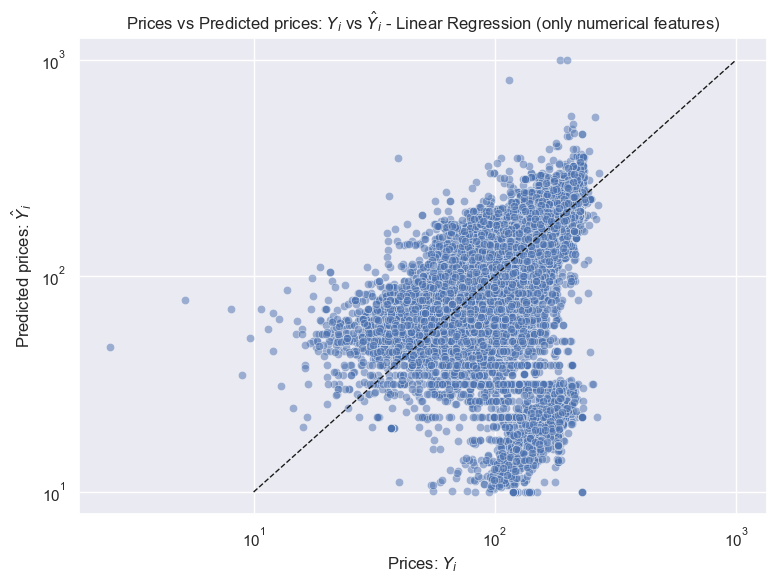

In [22]:
# 선형 회귀 모델의 예측 결과 시각화
y_test_pred_lin_reg_num_cols = lin_reg_num_cols.predict(X_test_num_cols)

plt_model(lin_reg_num_cols, y_test, y_test_pred_lin_reg_num_cols, 'Linear Regression (only numerical features)', show_feature_importance=False)

모든 지표에서 수치형 변수들만 사용했을 때 모델의 성능이 더 안 좋아진 것을 볼 수 있습니다.

---
### 2. Random Forest Regression Model

In [23]:
# 랜덤 포레스트 회귀 모델 학습
rf_reg = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=4)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, n_jobs=4, random_state=42)

In [24]:
# 랜덤 포레스트 회귀 모델의 성능 평가
evaluate_model(rf_reg, X_train, X_test, y_train, y_test, 'Random Forest')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Random Forest,3.664058,9.5826,62.934652,414.13072,7.933136,20.350202,0.977432,0.852122


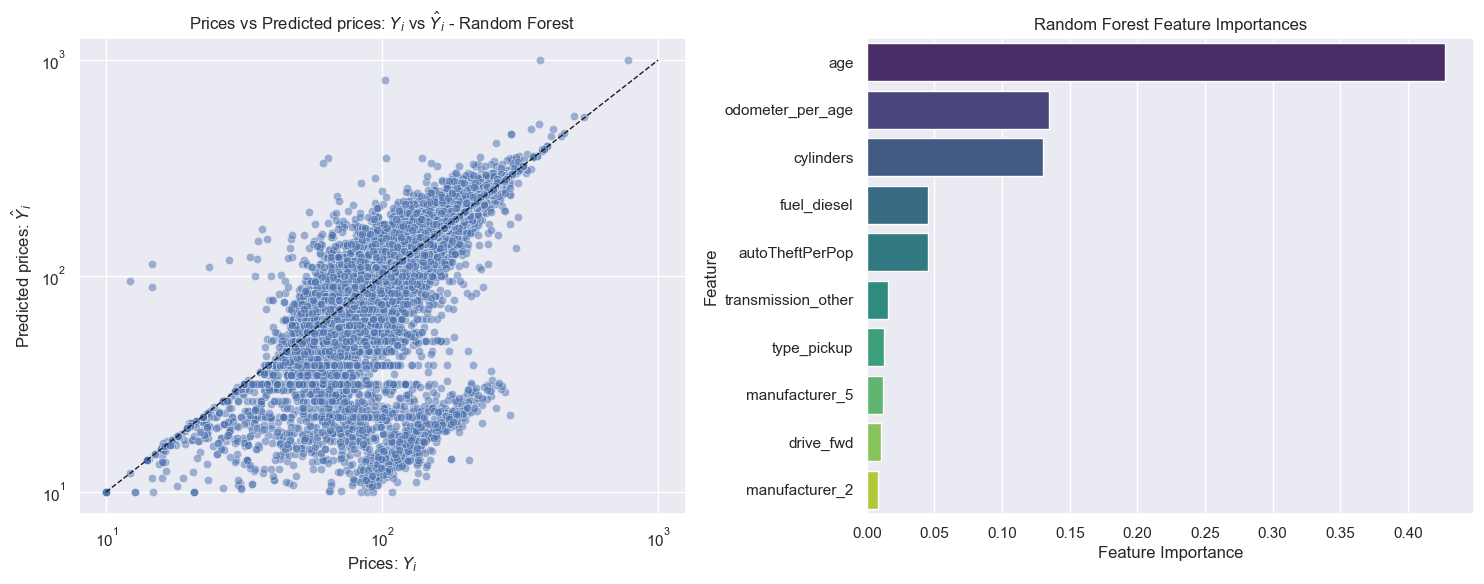

In [25]:
# 랜덤 포레스트 회귀 모델의 예측 결과 시각화
y_test_pred_rf = rf_reg.predict(X_test)

plt_model(rf_reg, y_test, y_test_pred_rf, 'Random Forest', show_feature_importance=True)

---
### 3. KNN Model

In [26]:
# KNN Regressor 모델 학습
knn_reg = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [27]:
# KNN Regressor 모델의 성능 평가
evaluate_model(knn_reg, X_train, X_test, y_train, y_test, 'KNN')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
KNN,10.204566,13.032676,379.289114,604.053374,19.475346,24.577497,0.863991,0.784304


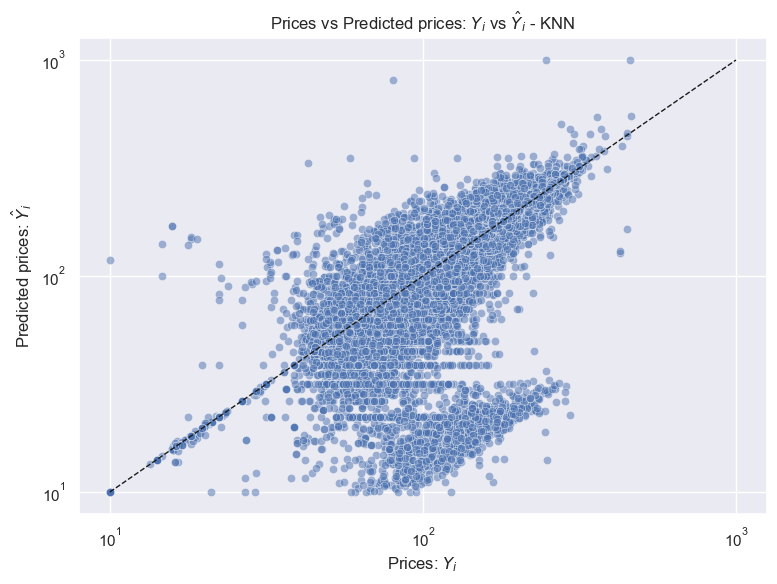

In [28]:
# KNN Regressor 모델의 예측 결과 시각화
y_test_pred_knn = knn_reg.predict(X_test)

plt_model(knn_reg, y_test, y_test_pred_knn, 'KNN')

---
### 4. XGBoost Regressor Model

In [29]:
# XGBoost Regressor 모델 학습
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [30]:
# XGBoost Regressor 모델의 성능 평가
evaluate_model(xgb_reg, X_train, X_test, y_train, y_test, 'XGBoost')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
XGBoost,13.42437,13.930109,525.858373,588.167085,22.931602,24.252156,0.811433,0.789977


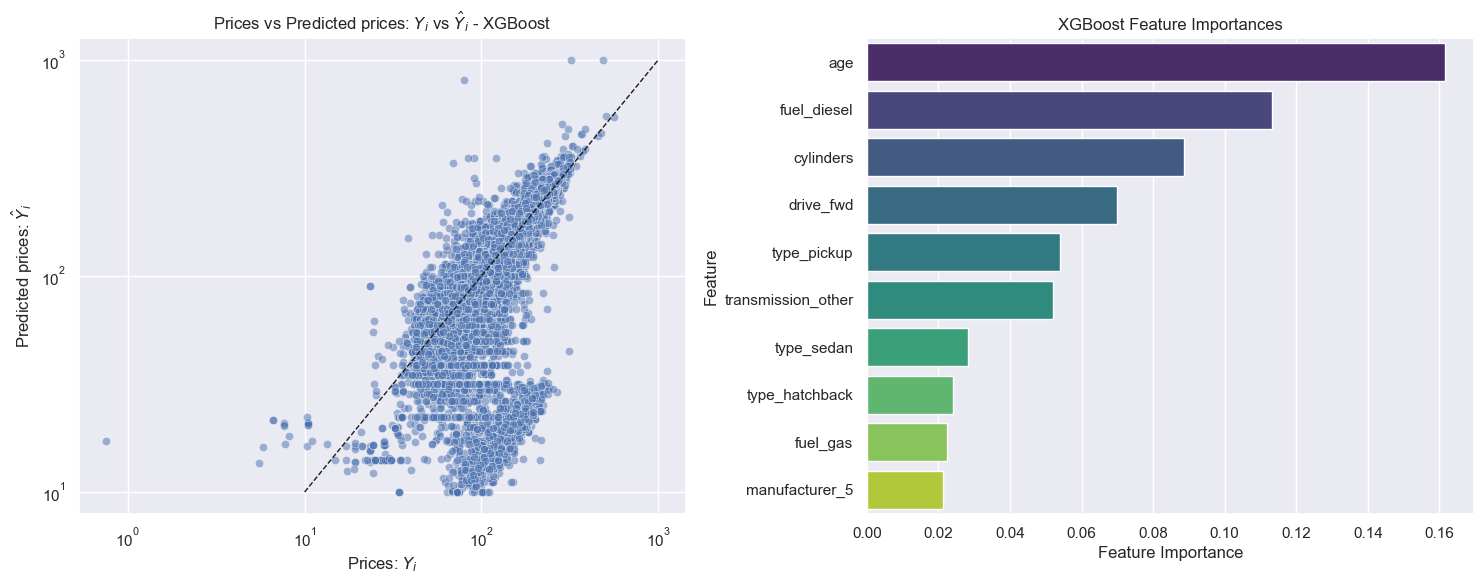

In [31]:
# XGBoost Regressor 모델의 예측 결과 시각화
y_test_pred_xgb = xgb_reg.predict(X_test)

plt_model(xgb_reg, y_test, y_test_pred_xgb, 'XGBoost', show_feature_importance=True)

---

### 모델별 성능 비교

In [33]:
eval_all_metrics_df = pd.DataFrame(eval_metrics_dict).T
eval_all_metrics_df.loc[['Linear Regression', 'Random Forest', 'KNN', 'XGBoost'], :].sort_values(by='Test R^2', ascending=False)

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Random Forest,3.664058,9.582600,62.934652,414.130720,7.933136,20.350202,0.977432,0.852122
XGBoost,13.424370,13.930109,525.858373,588.167085,22.931602,24.252156,0.811433,0.789977
KNN,10.204566,13.032676,379.289114,604.053374,19.475346,24.577497,0.863991,0.784304
Linear Regression,20.164879,20.177666,986.535521,997.712459,31.409163,31.586587,0.646238,0.643736


Random Forest 모델이 가장 낮은 MAE, MSE, RMSE 값과 가장 높은 $R^2$을 가지며 가장 좋은 성능을 보여줍니다.

XGBoost와 KNN은 비슷한 성능을 보여줍니다.

Linear Regression의 성능이 가장 낮은 것을 볼 수 있습니다.

---
---
## Cross Validation으로 최적 hyperparameter 찾기
위 값들은 임의의 hyperparamter를 사용한 모델들이기에 최적의 hyperparameter를 Cross Validation을 사용하여 찾아주겠습니다.

최적 hyperparameter 찾는 속도를 올려주기 위해 랜덤으로 샘플링한 데이터에 대해서만 Cross Validation을 적용하겠습니다.

In [32]:
# Cross Validation을 적용할 랜덤 샘플링
X_train_sampled = X_train.sample(frac=0.1, random_state=42)
y_train_sampled = y_train.loc[X_train_sampled.index]

### 1. 선형회귀 모델에 Lasso, Ridge 적용

In [33]:
# Ridge와 Lasso 모델 사용
ridge = Ridge()
lasso = Lasso()

# Ridge와 Lasso 모델의 하이퍼파라미터 튜닝을 위한 그리드 탐색
param_grid = {'alpha': np.logspace(0, 5, 100)}

# Ridge와 Lasso 모델의 하이퍼파라미터 튜닝을 위한 랜덤 탐색
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, n_jobs=-1)
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, n_jobs=-1)

ridge_cv.fit(X_train_sampled, y_train_sampled)
lasso_cv.fit(X_train_sampled, y_train_sampled)

# Ridge와 Lasso 모델의 최적 하이퍼 파리미터 출력
print('Ridge best alpha:', ridge_cv.best_params_)
print('Lasso best alpha:', lasso_cv.best_params_)

Ridge best alpha: {'alpha': 16.297508346206442}
Lasso best alpha: {'alpha': 1.0}


In [34]:
# 최적 Ridge 모델의 성능 평가
evaluate_model(ridge_cv, X_train, X_test, y_train, y_test, 'Ridge')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Ridge,20.210938,20.215609,989.559753,1000.288636,31.457269,31.62734,0.645154,0.642817


In [35]:
# 최적 Lasso 모델의 성능 평가
evaluate_model(lasso_cv, X_train, X_test, y_train, y_test, 'Lasso')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Lasso,21.334666,21.349321,1061.039178,1072.156901,32.573596,32.743807,0.619522,0.617154


### 2. Random Forest Regressor

In [37]:
# 랜덤 포레스트 회귀 모델의 하이퍼파라미터 튜닝
param_dist = {'n_estimators': [50, 100, 200, 400],
              'max_depth': [5, 10, 20, 40, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

rf_reg_tuned = RandomizedSearchCV(RandomForestRegressor(random_state=42), 
                                  param_distributions=param_dist, n_iter=5, cv=5, 
                                  n_jobs=4, verbose=1, random_state=42, pre_dispatch='2*n_jobs')
rf_reg_tuned.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
rf_reg_tuned.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None}

In [38]:
# 최적의 하이퍼파라미터로 튜닝된 랜덤 포레스트 회귀 모델의 성능 평가
evaluate_model(rf_reg_tuned.best_estimator_, X_train, X_test, y_train, y_test, 'Random Forest Tuned')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Random Forest Tuned,3.572441,9.483471,59.926048,409.27892,7.741192,20.230643,0.978511,0.853855


### 3. KNN Model

In [41]:
# KNN Regressor 모델의 하이퍼파라미터 튜닝
param_dist = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski']}

knn_reg_tuned = RandomizedSearchCV(KNeighborsRegressor(), param_distributions=param_dist, n_iter=30, cv=5, n_jobs=6, 
                                   verbose=1, random_state=42, pre_dispatch='2*n_jobs')
knn_reg_tuned.fit(X_train_sampled, y_train_sampled)

# 최적의 하이퍼파라미터 출력
knn_reg_tuned.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'weights': 'distance', 'n_neighbors': 11, 'metric': 'euclidean'}

In [42]:
# 최적의 하이퍼파라미터로 튜닝된 KNN Regressor 모델의 성능 평가
evaluate_model(knn_reg_tuned.best_estimator_, X_train, X_test, y_train, y_test, 'KNN Tuned')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
KNN Tuned,14.940278,16.603097,698.232725,792.26198,26.424094,28.147149,0.749621,0.717099


### 4. XGBoost Model

In [43]:
# XGBoost Regressor 모델의 하이퍼파라미터 튜닝
param_dist = {'n_estimators': np.arange(50, 400, 50),
              'max_depth': [5, 10, 20, 40],
              'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'subsample': [0.5, 0.7, 1]}

xgb_reg_tuned = RandomizedSearchCV(XGBRegressor(random_state=42), param_distributions=param_dist, n_iter=30, cv=5, n_jobs=6, 
                                   verbose=1, random_state=42)
xgb_reg_tuned.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
xgb_reg_tuned.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'subsample': 0.5, 'n_estimators': 150, 'max_depth': 20, 'learning_rate': 0.1}

In [44]:
# 최적의 하이퍼파라미터로 튜닝된 XGBoost Regressor 모델의 성능 평가
evaluate_model(xgb_reg_tuned.best_estimator_, X_train, X_test, y_train, y_test, 'XGBoost Tuned')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
XGBoost Tuned,1.680222,9.458595,12.399157,387.785778,3.521244,19.692277,0.995554,0.861529


### 튜닝된 모델 성능 비교

In [47]:
## 모델별 성능 비교
eval_all_metrics_df = pd.DataFrame(eval_metrics_dict).T
eval_all_metrics_df.loc[['Lasso', 'Ridge', 'Random Forest Tuned', 'KNN Tuned', 'XGBoost Tuned'], :].sort_values(by='Test R^2', ascending=False)

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
XGBoost Tuned,1.680222,9.458595,12.399157,387.785778,3.521244,19.692277,0.995554,0.861529
Random Forest Tuned,3.572441,9.483471,59.926048,409.278920,7.741192,20.230643,0.978511,0.853855
KNN Tuned,14.940278,16.603097,698.232725,792.261980,26.424094,28.147149,0.749621,0.717099
Ridge,20.210938,20.215609,989.559753,1000.288636,31.457269,31.627340,0.645154,0.642817
Lasso,21.334666,21.349321,1061.039178,1072.156901,32.573596,32.743807,0.619522,0.617154


셋 중에 RMSE가 가장 낮고 $R^2$값이 가장 높은 XGBoost Regressor 모델을 시각화 해보겠습니다.

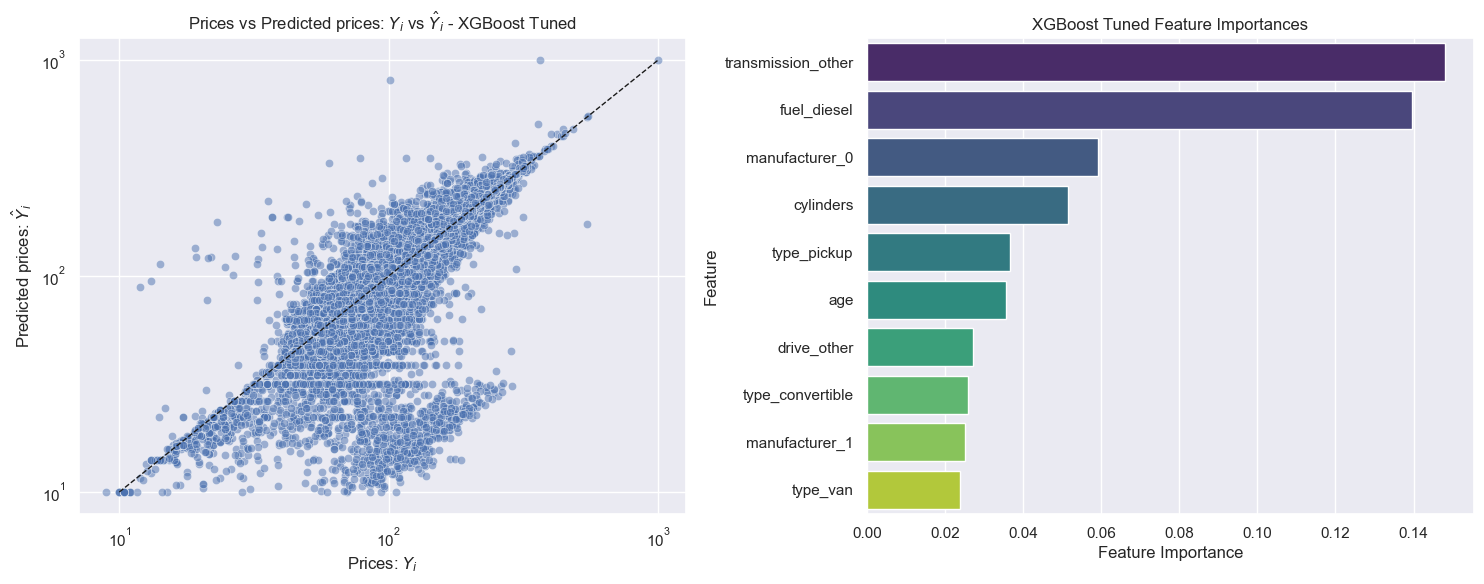

In [86]:
y_predict_tuned = xgb_reg_tuned.best_estimator_.predict(X_test)

plt_model(xgb_reg_tuned.best_estimator_, y_test, y_predict_tuned,
          'XGBoost Tuned', show_feature_importance=True, n_features=10)

---

## 잔차 분석


In [ ]:
# 잔차 계산
residuals = y_test - y_predict_tuned

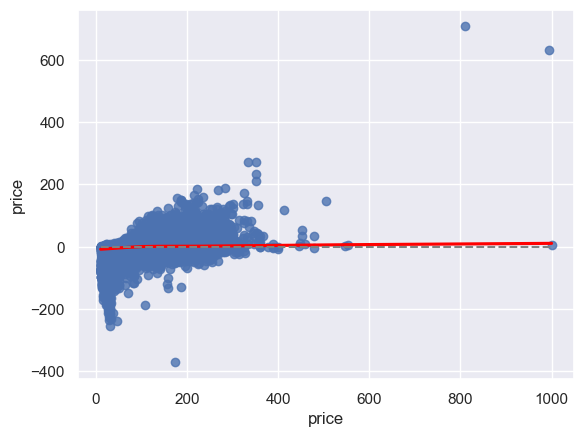

In [105]:
# 모형의 선형성 검정
sns.regplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.plot([y_test.min(), y_test.max()], [0, 0], '--', color='grey')
plt.show()

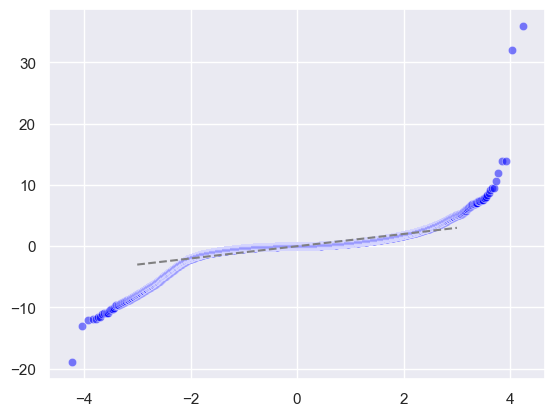

In [102]:
# 잔차의 정규성 검정
sr = zscore(residuals)
(x, y), _ = probplot(sr)

# Q-Q plot 시각화
sns.scatterplot(x=x, y=y, color='blue', alpha=0.5)
plt.plot([-3, 3], [-3, 3], '--', color='grey')
plt.show()

## Feature Selection

방법: Backward Selection(후방 제거) Wrapper 방식
- 모든 변수를 갖고 시작
- 가장 덜 중요한 변수를 하나씩 제거하며 더 이상 성능 향상 없을 때까지 반복

피쳐 중요도를 기준으로 내림차순으로 정렬한 뒤 하나하나 피쳐를 제거하면서 모델의 성능을 테스트 하였습니다.

In [49]:
# 피쳐 중요도를 내림차순으로 정렬
thresholds = np.sort(list(xgb_reg_tuned.best_estimator_.feature_importances_))

# 가장 성능 좋은 모델 선택
model = xgb_reg_tuned.best_estimator_

# 결과 저장할 리스트 생성
thresh_list = []
r2_list = []
num_features_list = []
features_dropped = []

for i, thresh in enumerate(thresholds):
    
    # 피쳐 중요도에 한계선를 적용하여 피쳐 선택
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train.values)
    
    # 한계선 이상인 피쳐만 선택하여 모델 학습
    selection_model = XGBRegressor(n_estimators=400, max_depth=10, learning_rate=0.1, colsample_bytree=0.5, subsample=1)
    selection_model.fit(select_X_train, y_train)
    
    # 모델 평가
    select_X_test = selection.transform(X_test.values)
    prediction = selection_model.predict(select_X_test)
    score = r2_score(y_test, prediction)
    
    # 결과 저장
    n_features_used = selection.get_feature_names_out(X_train.columns)
    if i > 0:
        features_dropped.append(set(features_used) - set(n_features_used))
    features_used = n_features_used
    thresh_list.append(thresh)
    r2_list.append(score)
    num_features_list.append(select_X_train.shape[1])

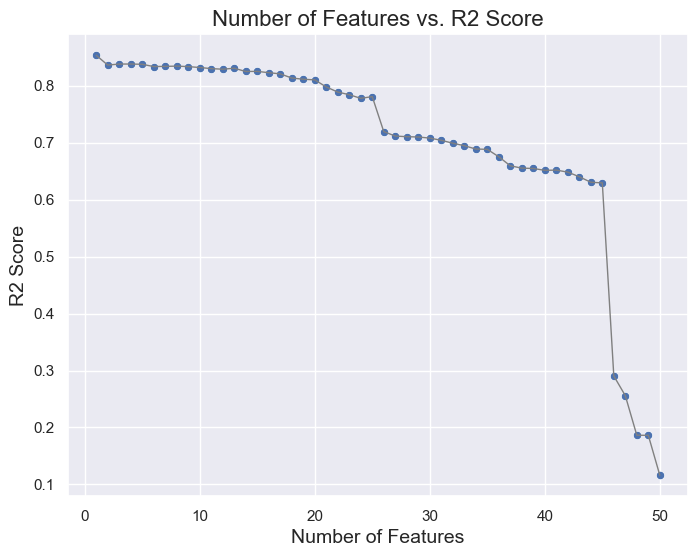

In [61]:
# 피쳐 개수에 따른 R2 점수 시각화
plt.figure(figsize=(8, 6))

sns.scatterplot(x=num_features_list[::-1], y=r2_list)
plt.plot(num_features_list[::-1], r2_list, color='gray', linewidth=1)

plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('R2 Score', fontsize=14)
plt.title('Number of Features vs. R2 Score', fontsize=16)
plt.grid(True)
plt.show()

피쳐 개수를 중요도 순으로 줄일수록 오히려 모델의 성능이 안 좋아지는 것을 볼 수 있습니다.

In [79]:
# 각 피쳐 제거 단계별 정보를 데이터프레임으로 변환
r2_df = pd.DataFrame({'r2_score': r2_list})
r2_df['diff_r2'] = r2_df['r2_score'].diff()
r2_df['dropped_feature'] = ['NaN'] + [str(feature).replace('{', '').replace('}', '').replace("'", '') for feature in features_dropped]
r2_df['num__remaining_features'] = num_features_list
r2_df

,r2_score,diff_r2,dropped_feature,num__remaining_features
0,0.853392,NaN,NaN,50
1,0.836200,-0.017192,autoTheftPerPop,49
2,0.837937,0.001738,model_0,48
3,0.837998,0.000061,drive_rwd,47
4,0.837521,-0.000477,model_7,46
5,0.833523,-0.003999,drive_4wd,45
6,0.833869,0.000347,model_10,44
7,0.834329,0.000460,model_1,43
8,0.833473,-0.000856,model_5,42
9,0.831875,-0.001598,fuel_hybrid,41


In [60]:
# 중요도 변화가 가장 큰 피쳐 5개
r2_df.sort_values(by='diff_r2', ascending=True).head(5)

,r2_score,diff_r2,dropped_feature,num__remaining_features
45,0.290509,-0.338861,{age},5
49,0.116185,-0.070123,{fuel_diesel},1
47,0.186378,-0.069496,{cylinders},3
25,0.719421,-0.061331,{odometer_per_age},25
46,0.255874,-0.034635,{type_pickup},4


제거됬을 때 가장 큰 중요도 변화 폭을 가져온 피쳐들은 연식, 디젤 차량 여부, 실린더 개수, 연간 주행거리, 픽업 트럭 여부이며,\
이 다섯개의 피쳐들이 모델의 예측 성능에 크게 기여한다는 것을 보여줍니다.

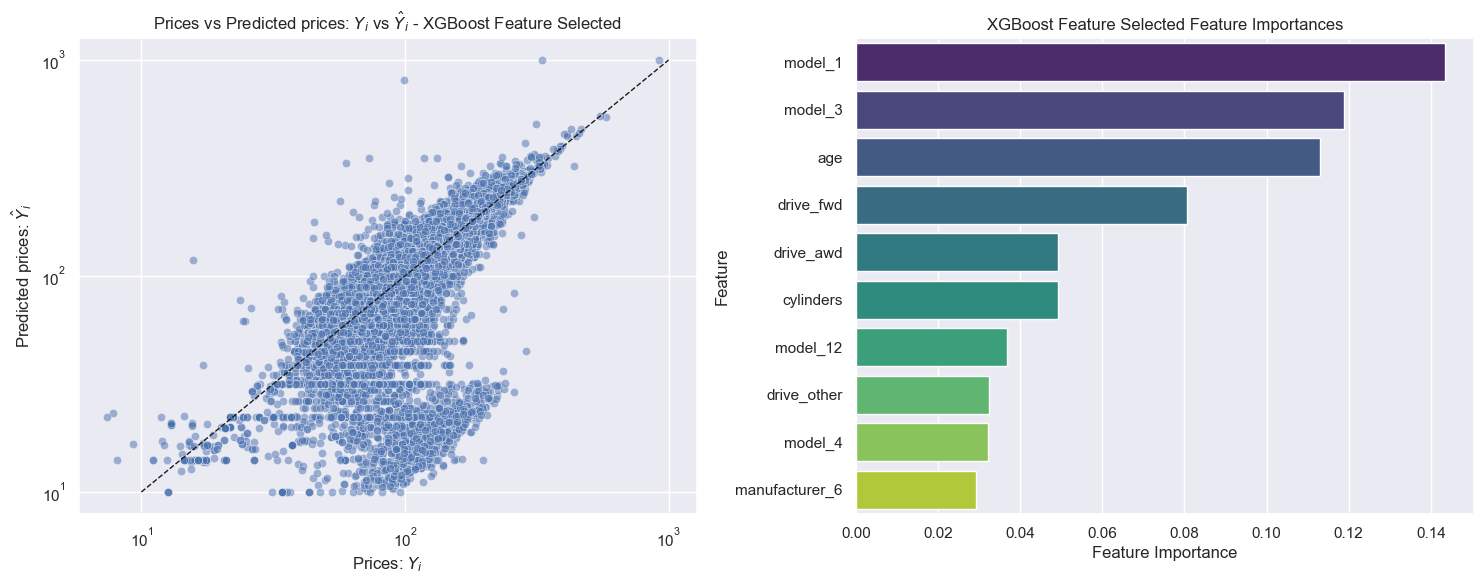

In [83]:
# 모델 중요도 변화가 가장 낮은 피쳐 20개를 제거
remove_features = r2_df.sort_values(by='diff_r2', ascending=False).head(20)['dropped_feature'].values

# 제거된 피쳐를 제외한 데이터로 모델 재학습
X_train_selected = X_train.drop(columns=remove_features)
X_test_selected = X_test.drop(columns=remove_features)

xgb_reg_selected = XGBRegressor(n_estimators=400, max_depth=10, learning_rate=0.1, colsample_bytree=0.5, subsample=1)
xgb_reg_selected.fit(X_train_selected, y_train)

# 제거된 피쳐를 제외한 데이터로 모델의 성능 평가
evaluate_model(xgb_reg_selected, X_train_selected, X_test_selected, y_train, y_test, 'XGBoost Feature Selected')

# 제거된 피쳐를 제외한 데이터로 모델의 예측 결과 시각화
y_test_pred_xgb_selected = xgb_reg_selected.predict(X_test_selected)

plt_model(xgb_reg_selected, y_test, y_test_pred_xgb_selected, 'XGBoost Feature Selected', show_feature_importance=True)

In [84]:
# 피쳐 선택 전/후 성능 평가 비교
eval_all_metrics_df = pd.DataFrame(eval_metrics_dict).T
eval_all_metrics_df.loc[['XGBoost Tuned', 'XGBoost Feature Selected'], :].sort_values(by='Test R^2', ascending=False)

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
XGBoost Tuned,1.680222,9.458595,12.399157,387.785778,3.521244,19.692277,0.995554,0.861529
XGBoost Feature Selected,8.804058,11.373256,247.677461,433.190353,15.737772,20.813225,0.911185,0.845316


피쳐를 제거해 줬을 때 오히려 성능이 떨어지는 것을 볼 수 있습니다.

---
---